In [1]:
import os
import collections
import itertools
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
from scipy.io import loadmat
from argparse import ArgumentParser

In [2]:
def get_gt(mat_data):
    # id: 0, objs: 3
    items = [(annots[0][0][0][0], annots[0][0][0][3]) for annots in mat_data]
    filt_list = ['phone', 'coat', 'surfboard', 'watch', 'trees',
                 'ball', 'bag', 'sofa', 'glasses', 'roof', 'boat']
    gt = []
    for item in items:
        objs = []
        for obj in item[1]:
            if obj[0][0][0][0][0] in filt_list:
                objs = []
                break
            objs.append([obj[0][0][0][0][0], obj[0][0][0][1][0]])
        if objs != []:
            gt.append((item[0][0], objs))

    return gt


def filt_cls(gts):
    filt_list = ['phone', 'coat', 'surfboard', 'watch', 'trees',
                 'ball', 'bag', 'sofa', 'glasses', 'roof', 'boat']
    rm_lst = []
    for gt in gts:
        for bbox in gt[1]:
            if bbox[0] in filt_list:
                rm_lst.append(gt)
                break
    for rm_elem in rm_lst:
        gts.remove(rm_elem)

    return gts


def get_gt_no_filt(mat_data):
    # id: 0, objs: 3
    items = [(annots[0][0][0][0], annots[0][0][0][3]) for annots in mat_data]
    gt = []
    for item in items:
        objs = []
        for obj in item[1]:
            objs.append([obj[0][0][0][0][0], obj[0][0][0][1][0]])
        gt.append((item[0][0], objs))

    return gt


def get_img_size(img_path, gt):
    img_full_names = [
            os.path.realpath(os.path.join(img_path, item[0])) for item in gt]

    return [Image.open(img).size for img in img_full_names]


def bbox_norm(s, gt, l):
    for idx in range(len(s)):
        objs = gt[idx][1]
        for obj in objs:
            # xmin     , ymin     , xmax     , ymax
            # obj[1][0], obj[1][1], obj[1][2], obj[1][3]
            # bbox = obj[1], idx_size = s[idx]

            # width = (x_max - x_min) / idx_size[0]
            width = float((obj[1][2] - obj[1][0]))
            # height = (y_max - y_min) / idx_size[1]
            height = float((obj[1][3] - obj[1][1]))
            # x_center = (x_min + width/2) / idx_size[0]
            x_center = float((obj[1][0] + width/2)) / s[idx][0]
            # y_center = (y_min + height/2) / idx_size[1]
            y_center = float((obj[1][1] + height/2)) / s[idx][1]

            # Update normalized bbox and binary label
            obj[1] = (x_center, y_center, width/s[idx][0], height/s[idx][1])
            obj[0] = l.index(obj[0])

    return gt


def find_labels(gts):
    checker = set()
    for img, gt in gts:
        for name, bbox in gt:
            checker.add(name)

    return list(checker)


def gt_nb_pimg(gts):
    """Calculate ground truth number in each image"""
    counter = collections.defaultdict(lambda: 0)
    for img_name, gt in gts:
        counter[len(gt)] += 1

    return pd.Series(counter).sort_values(ascending=False)


def cat_dist(gts):
    """Calculate counts distribution of each categories"""
    counter = collections.Counter()
    for img, gt in gts:
        for name, bbox in gt:
            counter.update([name])

    return pd.Series(counter).sort_values(ascending=False)


def cat_corr(gts):
    """Count correlationship between two categories"""
    counter = collections.Counter()
    for img, gt in gts:
        for pair in itertools.combinations([name for name, bbox in gt], 2):
            if pair[0] != pair[1]:
                counter.update([frozenset(pair)])

    # return pd.Series(counter).sort_values(ascending=False)
    return counter


def split_ds(gts, r=0.3):
    def tmp_cal(idxes):
        c = collections.defaultdict(lambda: 0)
        for i in idxes:
            for n, _ in gts[i][1]:
                c[n] += 1
        return c

    lbl_lst = cat_dist(gts)
    # Exclude top 3 classes, reverse
    balance_cls = lbl_lst[::-1]
    upper_bound = int(len(gts) * r)
    print(upper_bound)
    val_idx = set()
    added_lst = []
    for cls, counter in balance_cls.items():
        counter = int(counter * r) - tmp_cal(val_idx)[cls]
        for idx, (_, gt) in enumerate(gts):
            names = [n for n, _ in gt]
            include_added = bool(set(names).intersection(added_lst))
            if (counter <= 0) or (len(val_idx) > upper_bound):
                break
            elif cls in names and (not include_added):
                val_idx.add(idx)
                counter -= sum([True for n in names if n == cls])
        added_lst.append(cls)

    val_ds = []
    for idx in val_idx:
        val_ds.append(gts[idx])

    return val_ds



def img_size_dist(img_size_list):
    counter_dict = {'300-': 0, '600-': 0, '1000-': 0,
                    '1000+': 0, 'imbalance': 0}
    for img_size in img_size_list:
        if img_size[0] <= 300 and img_size[1] <= 300:
            counter_dict['300-'] += 1
        elif img_size[0] <= 600 and img_size[1] <= 600:
            counter_dict['600-'] += 1
        elif img_size[0] <= 1000 and img_size[1] <= 1000:
            counter_dict['1000-'] += 1
        elif img_size[0] > 1000 and img_size[1] > 1000:
            counter_dict['1000+'] += 1
        else:
            counter_dict['imbalance'] += 1

    return counter_dict

In [3]:
mat_path = "./annotations.mat"
img_path = "./images/"

mat_data = loadmat(mat_path)
ground_truth = get_gt_no_filt(mat_data['annotations'])
ground_truth = filt_cls(ground_truth)
print(len(ground_truth))
img_size = get_img_size(img_path, ground_truth)

1031


<BarContainer object of 15 artists>

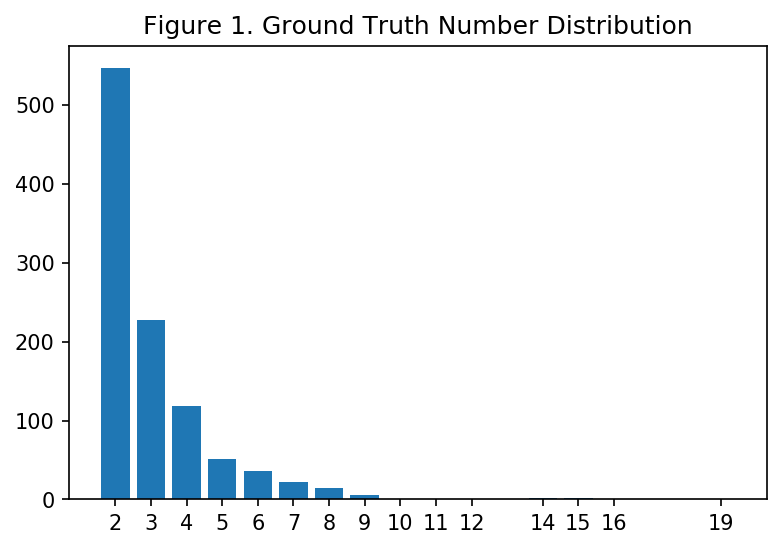

In [4]:
# Figure 1: show ground truth number distribution in each image
gt_nb_counter = gt_nb_pimg(ground_truth)
fig, ax = plt.subplots(1, 1, dpi=150)
ax.set_title("Figure 1. Ground Truth Number Distribution")
plt.xticks(gt_nb_counter.index)
ax.bar(gt_nb_counter.index, gt_nb_counter.values)

person           1130
dog               361
car               322
chair              90
elephant           89
tree               82
shoes              80
building           67
bike               66
cat                61
suitcase           60
wheel              58
cone               55
sunglasses         52
pants              49
horse              44
hat                44
box                42
table              37
plane              33
bed                33
jacket             28
road               28
refrigerator       27
cart               24
tie                22
shirt              21
umbrella           21
bench              19
train              19
giraffe            17
traffic light      16
truck              16
motorcycle         15
skateboard         14
helmet             13
bus                12
dtype: int64


<BarContainer object of 37 artists>

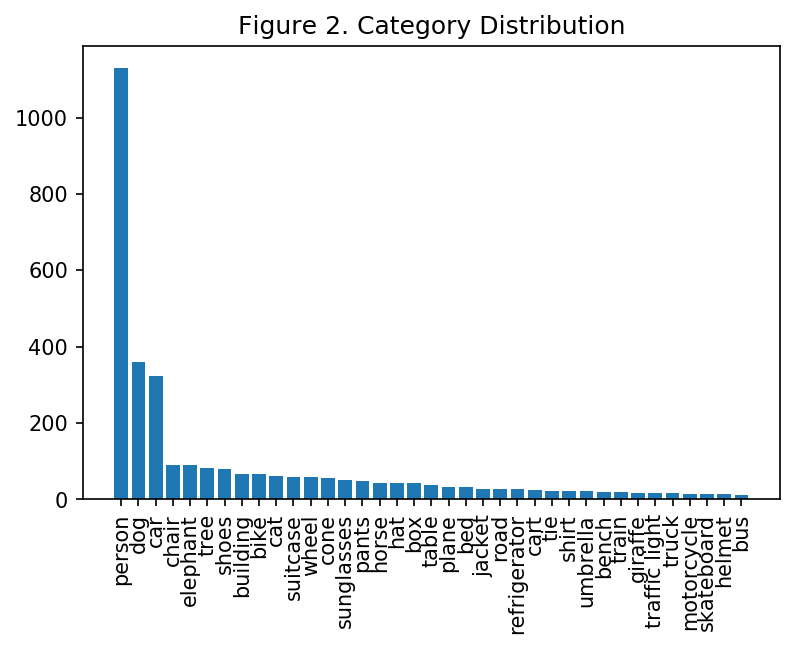

In [5]:
# Figure 2: show each categories distribution
categories_distribution = cat_dist(ground_truth)
print(categories_distribution)
fig, ax = plt.subplots(1, 1, dpi=150)
plt.xticks(rotation=90)
ax.set_title("Figure 2. Category Distribution")
ax.bar(categories_distribution.index, categories_distribution.values)

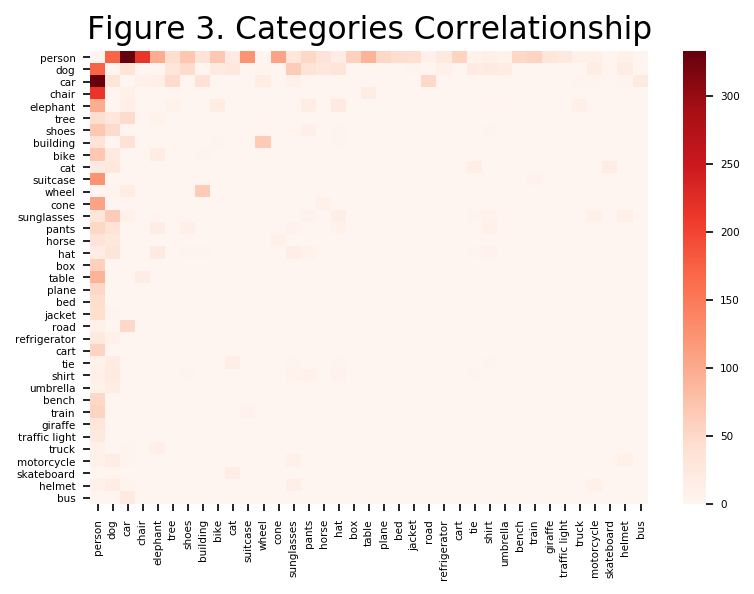

In [10]:
# Figure 3: Categories Correlationship
categories_correlation = cat_corr(ground_truth)

keys = categories_distribution.index
df = pd.DataFrame(np.zeros((len(keys), len(keys))),
                      columns=keys, index=keys)
for i in categories_correlation.most_common():
    x, y = list(i[0])
    df.loc[x, y], df.loc[y, x] = i[1], i[1]
plt.rcParams['font.size'] = 5
fig, ax = plt.subplots(1, 1, dpi=150)
ax.set_title("Figure 3. Categories Correlationship", size=15)
sns.heatmap(df, cmap='Reds', xticklabels=True, yticklabels=True)

<BarContainer object of 5 artists>

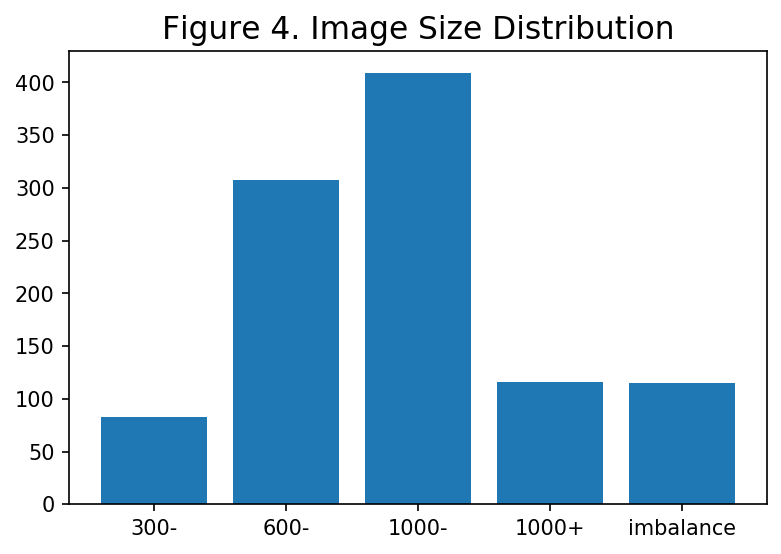

In [7]:
# Figure 4: Image Size Distribution
size_counter = img_size_dist(img_size)
fig, ax = plt.subplots(1, 1, dpi=150)
ax.set_title("Figure 4. Image Size Distribution", size=15)
ax.bar(size_counter.keys(), size_counter.values())

309


<BarContainer object of 37 artists>

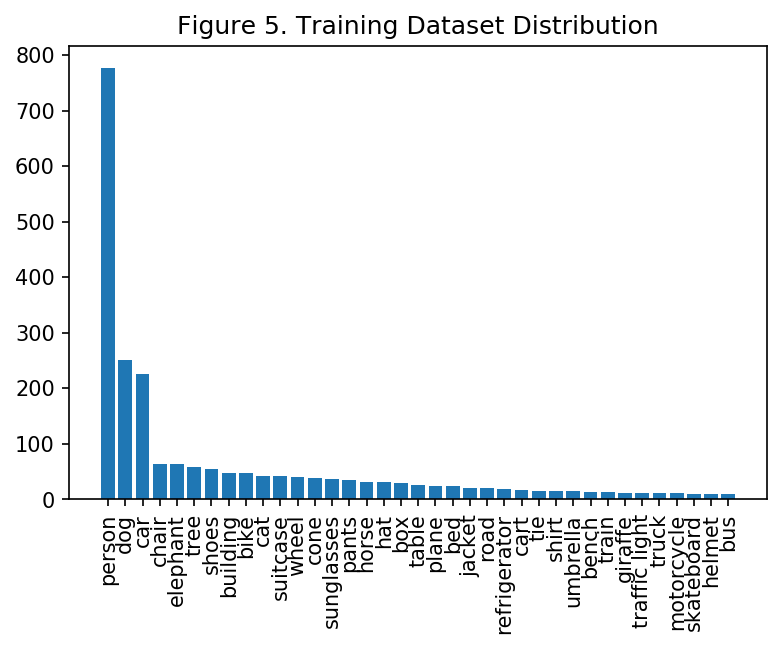

In [8]:
val_dataset = split_ds(ground_truth)
train_dataset = [gt for gt in ground_truth if gt not in val_dataset]
train_distribution = cat_dist(train_dataset)
fig, ax = plt.subplots(1, 1, dpi=150)
plt.xticks(rotation=90)
ax.set_title("Figure 5. Training Dataset Distribution")
ax.bar(categories_distribution.index, [train_distribution[c] for c in categories_distribution.index])

<BarContainer object of 37 artists>

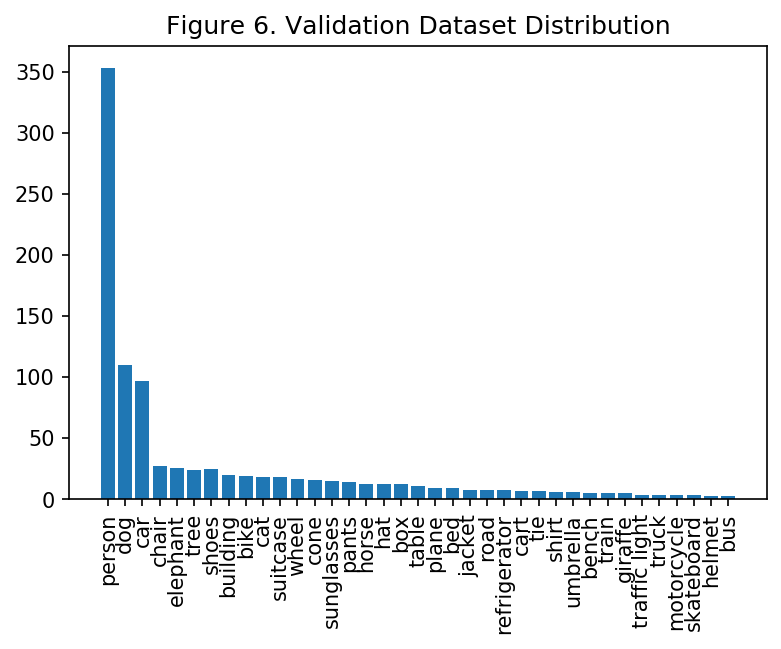

In [9]:
val_distribution = cat_dist(val_dataset)
fig, ax = plt.subplots(1, 1, dpi=150)
plt.xticks(rotation=90)
ax.set_title("Figure 6. Validation Dataset Distribution")
ax.bar(categories_distribution.index, [val_distribution[c] for c in categories_distribution.index])